# pickle

In [159]:
# save dfs to pickle
import pickle
with open('dfs.pkl', 'wb') as f:
    pickle.dump([X_train, X_test, y_train, y_test], f)

In [1]:
# load dfs from pickle
import pickle
with open('dfs.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

# Imports

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from scipy.stats import uniform
import xgboost as xgb

from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout

import tmdbsimple as tmdb
import time  # used to ensure the api query rate limit is abided by (~50 per second)
tmdb.API_KEY = '89c3bbcaee022e21c3f360047fac7542'

# Data Scraping

In [7]:
# gather data on movies coming out in the last week of the semester (April 4th - April 20th)

search = tmdb.Discover()

# define columns
columns = ['title', 'budget', 'genres', 'popularity', 'release_date', 'runtime', 'revenue']

# get total pages
response = search.movie(primary_release_date_gte='2024-04-14', primary_release_date_lte='2024-04-20', region='US', page=1)
total_pages = response['total_pages']

# gather data
new_df_list = []
for page in tqdm(range(1, total_pages)):
    response = search.movie(primary_release_date_gte='2024-04-14', primary_release_date_lte='2024-04-20', region='US', page=page)
    id_row = [result['id'] for result in response['results']]
    
    for ID in id_row:
        movie = tmdb.Movies(ID)
        movie_info = movie.info()
        
        # guard against missing budget and runtime
        if movie_info['budget'] == 0 or movie_info['runtime'] == 0:
            continue

        row = [movie_info[col] for col in columns]  # creates row of data
        row[2] = [genre['name'] for genre in row[2]]  # reformat genres to only include the names
        new_df_list.append(row)
        
    time.sleep(1)  # wait to abide by query rate limit
    
# convert to dataframe
new_df = pd.DataFrame(np.array(new_df_list, dtype=object), columns=columns)
new_df

100%|██████████| 13/13 [01:01<00:00,  4.72s/it]


,title,budget,genres,popularity,release_date,runtime,revenue
0,Rebel Moon - Part Two: The Scargiver,83000000,"[Action, Science Fiction, Drama]",61.469,2024-04-19,123,0
1,Villains Incorporated,1500000,[Comedy],5.92,2024-04-19,103,0
2,Sinners in the Hands of an Angry God,3000,"[Western, Drama]",5.3,2024-04-18,94,0
3,Safe/Sound,100000,[Thriller],4.04,2024-04-15,40,0
4,Nicole,3000,[],3.924,2024-04-14,6,0
5,The Vanishing Soldier,600000,"[Drama, Thriller, War]",3.799,2024-04-17,105,0
6,Eating 38 Cheeseburgers,10000,"[Comedy, Science Fiction]",3.611,2024-04-15,8,0
7,Don't Touch the Bump!,200,"[Comedy, Adventure, Fantasy, Science Fiction, ...",2.945,2024-04-20,81,0
8,The Mitch Wars: Part Two,540,"[Action, Drama, Science Fiction, Comedy, History]",2.789,2024-04-17,23,0
9,The Mitch Wars: Part Two,540,"[Action, Drama, Science Fiction, Comedy]",2.782,2024-04-17,25,0


In [8]:
# gather data on movies that came out 2018 - 2023

# get total pages
response = search.movie(primary_release_date_gte='2018-01-01', primary_release_date_lte='2023-12-31', region='US', page=1)
total_pages = response['total_pages']

# gather data
old_df_list = []
current_page = 1
while len(old_df_list) <= 1000 and current_page <= total_pages:
    print('current page:', current_page)
    print('movies to go:', 1000-len(old_df_list))
    print()
    response = search.movie(primary_release_date_gte='2018-01-01', primary_release_date_lte='2023-12-31', region='US', page=current_page)
    id_row = [result['id'] for result in response['results']]
    
    for ID in id_row:
        movie = tmdb.Movies(ID)
        movie_info = movie.info()
        
        # guard against missing revenue, budget, and runtime
        if movie_info['revenue'] == 0 or movie_info['budget'] == 0 or movie_info['runtime'] == 0:
            continue

        row = [movie_info[col] for col in columns]  # creates row of data
        row[2] = [genre['name'] for genre in row[2]]  # reformat genres to only include the names
        old_df_list.append(row)
        
    time.sleep(1)  # wait to abide by query rate limit
    current_page += 1  # increment page number
    
# convert to dataframe
old_df = pd.DataFrame(np.array(old_df_list, dtype=object), columns=columns)
old_df

current page: 1
movies to go 1000

current page: 2
movies to go 987

current page: 3
movies to go 978

current page: 4
movies to go 964

current page: 5
movies to go 954

current page: 6
movies to go 942

current page: 7
movies to go 929

current page: 8
movies to go 920

current page: 9
movies to go 907

current page: 10
movies to go 896

current page: 11
movies to go 885

current page: 12
movies to go 871

current page: 13
movies to go 858

current page: 14
movies to go 848

current page: 15
movies to go 834

current page: 16
movies to go 821

current page: 17
movies to go 809

current page: 18
movies to go 798

current page: 19
movies to go 788

current page: 20
movies to go 779

current page: 21
movies to go 766

current page: 22
movies to go 757

current page: 23
movies to go 747

current page: 24
movies to go 738

current page: 25
movies to go 726

current page: 26
movies to go 714

current page: 27
movies to go 704

current page: 28
movies to go 695

current page: 29
movies to g

current page: 233
movies to go 28

current page: 234
movies to go 26

current page: 235
movies to go 25

current page: 236
movies to go 24

current page: 237
movies to go 23

current page: 238
movies to go 22

current page: 239
movies to go 21

current page: 240
movies to go 20

current page: 241
movies to go 20

current page: 242
movies to go 20

current page: 243
movies to go 20

current page: 244
movies to go 18

current page: 245
movies to go 16

current page: 246
movies to go 16

current page: 247
movies to go 16

current page: 248
movies to go 16

current page: 249
movies to go 15

current page: 250
movies to go 14

current page: 251
movies to go 13

current page: 252
movies to go 11

current page: 253
movies to go 11

current page: 254
movies to go 10

current page: 255
movies to go 9

current page: 256
movies to go 8

current page: 257
movies to go 8

current page: 258
movies to go 7

current page: 259
movies to go 5

current page: 260
movies to go 4

current page: 261
movies t

,title,budget,genres,popularity,release_date,runtime,revenue
0,Creation of the Gods I: Kingdom of Storms,85000000,"[Action, Fantasy, War]",970.826,2023-07-20,148,372945000
1,Migration,72000000,"[Animation, Action, Adventure, Comedy, Family]",858.977,2023-12-06,83,292219000
2,Alienoid,24500000,"[Science Fiction, Action, Fantasy, Adventure]",768.866,2022-07-20,142,12600000
3,Godzilla vs. Kong,200000000,"[Action, Science Fiction, Thriller]",532.511,2021-03-24,114,470116094
4,Godzilla Minus One,13000000,"[Science Fiction, Horror, Action]",512.953,2023-11-03,125,105100000
...,...,...,...,...,...,...,...
997,Abang Adik,653000,"[Drama, Crime]",11.318,2023-12-01,115,1363827
998,2.0,77000000,"[Action, Science Fiction, Fantasy]",11.26,2018-11-29,149,114629169
999,The Palace,18700000,"[Drama, Comedy]",11.24,2023-09-28,100,420350
1000,The Old Man & the Gun,15800000,"[Comedy, Crime, Drama]",11.105,2018-09-27,94,11277120


# Preprocessing


In [10]:
# merge dfs
new_df['upcoming'] = True
old_df['upcoming'] = False
full_df = pd.concat([new_df, old_df], ignore_index=True)
full_df.head(20)

,title,budget,genres,popularity,release_date,runtime,revenue,upcoming
0,Rebel Moon - Part Two: The Scargiver,83000000,"[Action, Science Fiction, Drama]",61.469,2024-04-19,123,0,True
1,Villains Incorporated,1500000,[Comedy],5.92,2024-04-19,103,0,True
2,Sinners in the Hands of an Angry God,3000,"[Western, Drama]",5.3,2024-04-18,94,0,True
3,Safe/Sound,100000,[Thriller],4.04,2024-04-15,40,0,True
4,Nicole,3000,[],3.924,2024-04-14,6,0,True
5,The Vanishing Soldier,600000,"[Drama, Thriller, War]",3.799,2024-04-17,105,0,True
6,Eating 38 Cheeseburgers,10000,"[Comedy, Science Fiction]",3.611,2024-04-15,8,0,True
7,Don't Touch the Bump!,200,"[Comedy, Adventure, Fantasy, Science Fiction, ...",2.945,2024-04-20,81,0,True
8,The Mitch Wars: Part Two,540,"[Action, Drama, Science Fiction, Comedy, History]",2.789,2024-04-17,23,0,True
9,The Mitch Wars: Part Two,540,"[Action, Drama, Science Fiction, Comedy]",2.782,2024-04-17,25,0,True


In [11]:
# convert datatypes
full_df['budget'] = pd.to_numeric(full_df['budget'])
full_df['popularity'] = pd.to_numeric(full_df['popularity'])
full_df['release_date'] = pd.to_datetime(full_df['release_date'])
full_df['runtime'] = pd.to_numeric(full_df['runtime'])
full_df['revenue'] = pd.to_numeric(full_df['revenue'])
full_df.dtypes

title                   object
budget                   int64
genres                  object
popularity             float64
release_date    datetime64[ns]
runtime                  int64
revenue                  int64
upcoming                  bool
dtype: object

In [12]:
full_df.describe(include='all', datetime_is_numeric=True)

,title,budget,genres,popularity,release_date,runtime,revenue,upcoming
count,1026,1.026000e+03,1026,1026.000000,1026,1026.000000,1.026000e+03,1026
unique,1024,NaN,491,NaN,NaN,NaN,NaN,2
top,The Mitch Wars: Part Two,NaN,[Drama],NaN,NaN,NaN,NaN,False
freq,2,NaN,46,NaN,NaN,NaN,NaN,1002
mean,NaN,4.093126e+07,NaN,52.731755,2020-11-23 11:58:35.789473792,111.667641,1.140174e+08,NaN
min,NaN,4.000000e+00,NaN,1.400000,2018-01-03 00:00:00,2.000000,0.000000e+00,NaN
25%,NaN,6.500000e+06,NaN,21.473000,2019-03-13 06:00:00,98.000000,3.887047e+06,NaN
50%,NaN,1.800000e+07,NaN,32.967000,2020-10-01 12:00:00,109.000000,2.186078e+07,NaN
75%,NaN,4.500000e+07,NaN,56.853750,2022-08-21 00:00:00,124.000000,9.577165e+07,NaN
max,NaN,4.600000e+08,NaN,970.826000,2024-04-20 00:00:00,209.000000,2.800000e+09,NaN


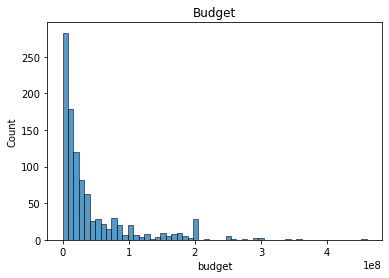

In [13]:
sns.histplot(data=full_df[full_df['upcoming']==False], x='budget')
plt.title('Budget')
plt.show()

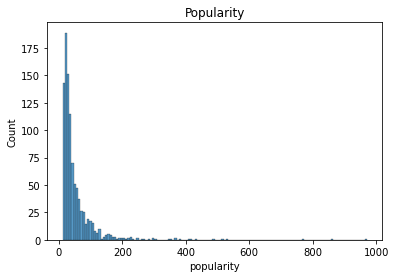

In [14]:
sns.histplot(data=full_df[full_df['upcoming']==False], x='popularity')
plt.title('Popularity')
plt.show()

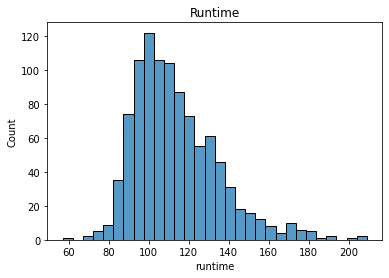

In [15]:
sns.histplot(data=full_df[full_df['upcoming']==False], x='runtime')
plt.title('Runtime')
plt.show()

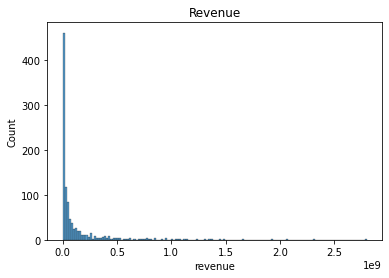

In [16]:
# heavily skewed
sns.histplot(data=full_df[full_df['upcoming']==False], x='revenue')
plt.title('Revenue')
plt.show()

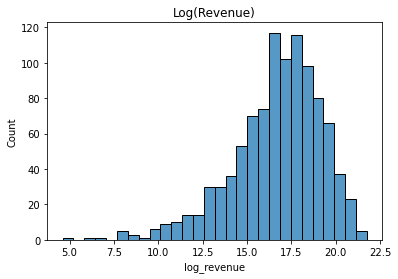

In [163]:
# much better
old_df['log_revenue'] = np.log(full_df[full_df['upcoming']==False]['revenue'])
sns.histplot(data=old_df, x='log_revenue')
plt.title("Log(Revenue)")
plt.show()

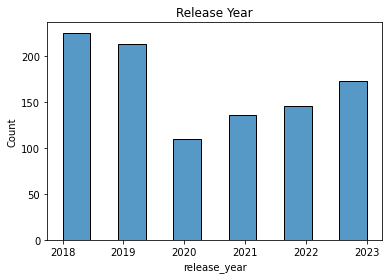

In [28]:
full_df['release_year'] = full_df['release_date'].dt.year
sns.histplot(data=full_df[full_df['upcoming']==False], x='release_year')
plt.title('Release Year')
plt.show()

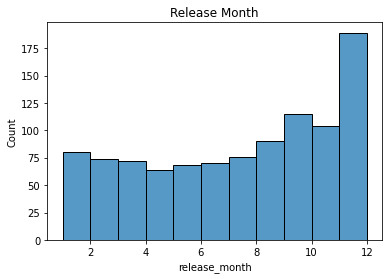

In [29]:
full_df['release_month'] = full_df['release_date'].dt.month
sns.histplot(data=full_df[full_df['upcoming']==False], x='release_month')
plt.title('Release Month')
plt.show()

In [32]:
# drop title and release date
df = full_df.drop(['title', 'release_date'], axis='columns')

# create genre dummy columns and drop original genre columns (used chatGPT to help with this)
genres = set(genre for genre_row in df['genres'] for genre in genre_row)
dummy_df = pd.DataFrame(0, index=df.index, columns=genres)
for i, row in df.iterrows():
    dummy_df.loc[i, row['genres']] = 1
df = pd.concat([df, dummy_df], axis=1)
df.drop(['genres'], axis='columns', inplace=True)

# create release_month dummy columns
df = pd.concat([df.drop('release_month', axis='columns'), pd.get_dummies(df['release_month'], prefix='release_month')], axis='columns')

# split by upcoming
old_df = df[df['upcoming']==False].copy()
new_df = df[df['upcoming']==True].copy()
old_df['log_revenue'] = np.log(old_df['revenue'])
old_df.drop('revenue', axis='columns', inplace=True)

# drop upcoming
old_df.drop(['upcoming'], axis='columns', inplace=True)
new_df.drop(['upcoming'], axis='columns', inplace=True)
old_df.head()

,budget,popularity,runtime,release_year,War,Comedy,Mystery,Horror,Western,Fantasy,...,release_month_4,release_month_5,release_month_6,release_month_7,release_month_8,release_month_9,release_month_10,release_month_11,release_month_12,log_revenue
24,85000000,970.826,148,2023,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,19.736942
25,72000000,858.977,83,2023,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,19.493014
26,24500000,768.866,142,2022,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,16.349207
27,200000000,532.511,114,2021,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19.968490
28,13000000,512.953,125,2023,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,18.470423


In [33]:
old_df.corr()['log_revenue'].sort_values(ascending=False)  # budget, popularity, runtime, and certain genres are highly correlated with revenue

log_revenue         1.000000
budget              0.533654
popularity          0.350063
runtime             0.297975
Adventure           0.266889
Family              0.147573
Animation           0.146560
Science Fiction     0.122289
Action              0.121075
Comedy              0.090051
Fantasy             0.074680
release_month_5     0.067955
release_month_3     0.066255
release_month_12    0.059634
release_month_7     0.046742
release_month_2     0.030000
Music               0.014965
release_month_6     0.009514
Mystery            -0.011762
Romance            -0.013642
release_month_11   -0.014344
Documentary        -0.016333
Western            -0.027255
release_month_1    -0.027551
release_month_4    -0.029382
release_year       -0.029726
release_month_8    -0.034794
History            -0.048019
release_month_10   -0.057668
Horror             -0.064486
War                -0.075464
release_month_9    -0.087034
Thriller           -0.091771
Crime              -0.092426
TV Movie      

In [53]:
# extract values
X = old_df.drop(['log_revenue'], axis='columns').values
y = old_df['log_revenue'].astype(float).values

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

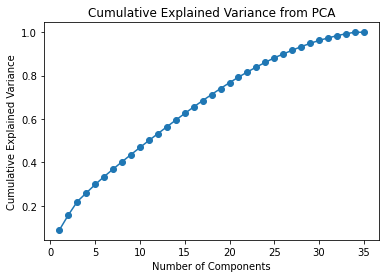

[0.0889742  0.15798235 0.21980143 0.25935734 0.29839835 0.33479091
 0.3695192  0.4032212  0.4364207  0.46908416 0.50121832 0.53278608
 0.56419867 0.59515578 0.62565402 0.65570093 0.68490076 0.71292625
 0.74059833 0.76757227 0.7930461  0.81694084 0.83978537 0.86122442
 0.88207338 0.8996471  0.91702162 0.93345095 0.94856327 0.96216337
 0.97358609 0.98419631 0.99288926 1.         1.        ]


In [166]:
# pca
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
cumulative_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, X_train.shape[1]+1), cumulative_explained_variance_ratio, marker='o')
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.title('Cumulative Explained Variance from PCA')
plt.show()
print(cumulative_explained_variance_ratio)

# use only enough to explain 0.95 of variation
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)

In [153]:
# linear regression
pipe = Pipeline(
    [
        ('pca', PCA()),
        ('lr', LinearRegression())
    ]
)
parameters = {
    'pca__n_components':range(1, X_train.shape[1]-1),
}

lr_search = GridSearchCV(pipe, parameters, cv=5)
lr_search.fit(X_train, y_train)
y_pred = lr_search.predict(X_test)

print("Best parameters found: ", lr_search.best_params_)
print("Best score found:", mean_squared_error(y_train, lr_search.predict(X_train)))
print('Test MSE:', mean_squared_error(y_test, y_pred))

Best parameters found:  {'pca__n_components': 30}
Best score found: 3.471961348340478
Test MSE: 5.044840640511334


In [108]:
# knn
pipe = Pipeline(
    [
        ('pca', PCA()),
        ('knn', KNeighborsRegressor())
    ]
)
parameters = {
    'pca__n_components':range(1, X_train.shape[1]-1),
    'knn__n_neighbors':range(1, 100)
}

search = RandomizedSearchCV(pipe, parameters, n_iter=100, cv=5)
search.fit(X_train, y_train)
y_pred = search.predict(X_test)

print("Best parameters found: ", search.best_params_)
print("Best score found:", mean_squared_error(y_train, search.predict(X_train)))
print('Test MSE:', mean_squared_error(y_test, y_pred))

Best parameters found:  {'pca__n_components': 9, 'knn__n_neighbors': 10}
Best score found: 4.088352237547944
Test MSE: 5.966204825790863


In [111]:
# decision tree
pipe = Pipeline(
    [
        ('pca', PCA()),
        ('dt', DecisionTreeRegressor())
    ]
)
parameters = {
    'pca__n_components':range(1, X_train.shape[1]-1),
    'dt__max_depth':range(1, 10)
}

search = GridSearchCV(pipe, parameters, cv=5)
search.fit(X_train, y_train)
y_pred = search.predict(X_test)

print("Best parameters found: ", search.best_params_)
print("Best score found:", mean_squared_error(y_train, search.predict(X_train)))
print('Test MSE:', mean_squared_error(y_test, y_pred))


Best parameters found:  {'dt__max_depth': 2, 'pca__n_components': 7}
Best score found: 4.7497704071088975
Test MSE: 6.40539078094186


In [113]:
# random forest
pipe = Pipeline(
    [
        ('pca', PCA()),
        ('rf', RandomForestRegressor())
    ]
)
parameters = {
    'pca__n_components':range(1, X_train.shape[1]-1),
    'rf__n_estimators':range(1,100),
    'rf__max_depth':range(1,10)
}

search = RandomizedSearchCV(pipe, parameters, n_iter=100, cv=5)
search.fit(X_train, y_train)
y_pred = search.predict(X_test)

print("Best parameters found: ", search.best_params_)
print("Best score found:", mean_squared_error(y_train, search.predict(X_train)))
print('Test MSE:', mean_squared_error(y_test, y_pred))

Best parameters found:  {'rf__n_estimators': 94, 'rf__max_depth': 7, 'pca__n_components': 28}
Best score found: 2.1422952576206127
Test MSE: 5.22603405533686


In [119]:
# adaboost
pipe = Pipeline(
    [
        ('pca', PCA()),
        ('ada', AdaBoostRegressor())
    ]
)
parameters = {
    'pca__n_components':range(1, X_train.shape[1]-1),
    'ada__n_estimators':range(1, 100),
    'ada__learning_rate':uniform(0, 1)
}

search = RandomizedSearchCV(pipe, parameters, n_iter=100, cv=5)
search.fit(X_train, y_train)
y_pred = search.predict(X_test)

print("Best parameters found:", search.best_params_)
print("Best score found:", mean_squared_error(y_train, search.predict(X_train)))
print('Test MSE:', mean_squared_error(y_test, y_pred))

Best parameters found:  {'ada__learning_rate': 0.7100079768735679, 'ada__n_estimators': 16, 'pca__n_components': 27}
Best score found: 3.9443877878994806
Test MSE: 5.773371389810568


In [157]:
# svr
pipe = Pipeline(
    [
        ('pca', PCA()),
        ('svr', SVR())
    ]
)
parameters = {
    'pca__n_components':range(1, X_train.shape[1]-1),
    'svr__kernel':['linear', 'poly', 'rbf', 'sigmoid']
}

svr_search = GridSearchCV(pipe, parameters, cv=5)
svr_search.fit(X_train, y_train)
y_pred = svr_search.predict(X_test)

print("Best parameters found: ", svr_search.best_params_)
print("Best score found:", mean_squared_error(y_train, svr_search.predict(X_train)))
print('Test MSE:', mean_squared_error(y_test, y_pred))

Best parameters found:  {'pca__n_components': 33, 'svr__kernel': 'rbf'}
Best score found: 2.9947006292056986
Test MSE: 4.953640568083265


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_95 (Dense)            (None, 32)                1152      
                                                                 
 dropout_49 (Dropout)        (None, 32)                0         
                                                                 
 dense_96 (Dense)            (None, 64)                2112      
                                                                 
 dropout_50 (Dropout)        (None, 64)                0         
                                                                 
 dense_97 (Dense)            (None, 128)               8320      
                                                                 
 dropout_51 (Dropout)        (None, 128)               0         
                                                                 
 dense_98 (Dense)            (None, 256)             

20/20 [==============================] - 0s 5ms/step - loss: 4.5647 - mean_squared_error: 4.5647 - val_loss: 9.0567 - val_mean_squared_error: 9.0567
Epoch 41/100
20/20 [==============================] - 0s 4ms/step - loss: 4.4792 - mean_squared_error: 4.4792 - val_loss: 9.1472 - val_mean_squared_error: 9.1472
Epoch 42/100
20/20 [==============================] - 0s 4ms/step - loss: 4.4039 - mean_squared_error: 4.4039 - val_loss: 9.5552 - val_mean_squared_error: 9.5552
Epoch 43/100
20/20 [==============================] - 0s 4ms/step - loss: 4.8763 - mean_squared_error: 4.8763 - val_loss: 8.6252 - val_mean_squared_error: 8.6252
Epoch 44/100
20/20 [==============================] - 0s 7ms/step - loss: 4.9309 - mean_squared_error: 4.9309 - val_loss: 7.2390 - val_mean_squared_error: 7.2390
Epoch 45/100
20/20 [==============================] - 0s 4ms/step - loss: 4.4477 - mean_squared_error: 4.4477 - val_loss: 10.2071 - val_mean_squared_error: 10.2071
Epoch 46/100
20/20 [===================

20/20 [==============================] - 0s 4ms/step - loss: 3.8015 - mean_squared_error: 3.8015 - val_loss: 6.6402 - val_mean_squared_error: 6.6402
Epoch 91/100
20/20 [==============================] - 0s 4ms/step - loss: 3.7196 - mean_squared_error: 3.7196 - val_loss: 7.0244 - val_mean_squared_error: 7.0244
Epoch 92/100
20/20 [==============================] - 0s 4ms/step - loss: 3.6279 - mean_squared_error: 3.6279 - val_loss: 6.9988 - val_mean_squared_error: 6.9988
Epoch 93/100
20/20 [==============================] - 0s 4ms/step - loss: 3.4104 - mean_squared_error: 3.4104 - val_loss: 6.6222 - val_mean_squared_error: 6.6222
Epoch 94/100
20/20 [==============================] - 0s 5ms/step - loss: 3.4114 - mean_squared_error: 3.4114 - val_loss: 5.5587 - val_mean_squared_error: 5.5587
Epoch 95/100
20/20 [==============================] - 0s 6ms/step - loss: 3.4491 - mean_squared_error: 3.4491 - val_loss: 5.2158 - val_mean_squared_error: 5.2158
Epoch 96/100
20/20 [=====================

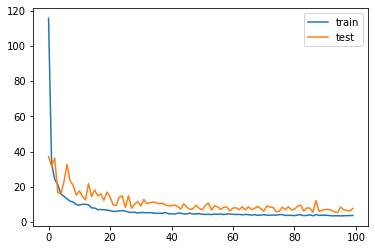

In [167]:
# nnet
# define model architecture
input_shape = (X_train.shape[1],)
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dense(1))

# compile
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
print(model.summary())

# train
checkpoint = ModelCheckpoint('weights.hdf5', monitor='val_loss', save_best_only=True)
history = model.fit(X_train, y_train, epochs=100, callbacks=[checkpoint], shuffle=True, validation_split=0.2)
model.load_weights('weights.hdf5')
model.evaluate(X_test, y_test)

# plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [133]:
# XGBoost
X_train_xg, X_val_xg, y_train_xg, y_val_xg = train_test_split(X_train, y_train, test_size=0.2)
clf = xgb.XGBRegressor(tree_method="hist", early_stopping_rounds=2)
clf.fit(X_train_xg, y_train_xg, eval_set=[(X_val_xg, y_val_xg)])

y_pred = clf.predict(X_test)
print('Test MSE:', mean_squared_error(y_test, y_pred))
np.exp(np.sqrt(mean_squared_error(y_test, y_pred)))  # error in terms of dollars

[0]	validation_0-rmse:2.03564
[1]	validation_0-rmse:1.89684
[2]	validation_0-rmse:1.82658
[3]	validation_0-rmse:1.76246
[4]	validation_0-rmse:1.74202
[5]	validation_0-rmse:1.72511
[6]	validation_0-rmse:1.73508
Test MSE: 3.920822360674869


7.243515492878113

In [173]:
# final prediction on movies coming out
final_X = new_df.drop('revenue', axis='columns').values
final_X = scaler.transform(final_X)

# XGBoost
y_pred = np.exp(clf.predict(final_X))
results_df = pd.DataFrame({
    'title':full_df[full_df['upcoming']==True]['title'],
    'XGB_predicted_revenue':y_pred
})
results_df['XGB_predicted_revenue'] = results_df['XGB_predicted_revenue'].astype(int)
results_df['title']

0     Rebel Moon - Part Two: The Scargiver
1                    Villains Incorporated
2     Sinners in the Hands of an Angry God
3                               Safe/Sound
4                                   Nicole
5                    The Vanishing Soldier
6                  Eating 38 Cheeseburgers
7                    Don't Touch the Bump!
8                 The Mitch Wars: Part Two
9                 The Mitch Wars: Part Two
10                The Siege: Archangel One
11                    Mourir or not mourir
12                                Aye Bruh
13                                  Addict
14                                 tenuous
15                    Bluebird in the Wind
16                              Dear Allie
17                                  Mother
18                              Cornucopia
19                      Contact (The Band)
20      SWELTERING HEAT...AL SUR DEL NORTE
21          And So, My Heart Became a Void
22                                Infirmus
23         

In [175]:
# linear regression
y_pred = np.exp(lr_search.predict(final_X))

results_df['lr_predicted_revenue'] = y_pred.astype(int)
results_df

,title,XGB_predicted_revenue,lr_predicted_revenue
0,Rebel Moon - Part Two: The Scargiver,85474216,6193229
1,Villains Incorporated,4424241,4064053
2,Sinners in the Hands of an Angry God,754680,785834
3,Safe/Sound,611676,261995
4,Nicole,611676,87215
5,The Vanishing Soldier,109867,635139
6,Eating 38 Cheeseburgers,611676,117393
7,Don't Touch the Bump!,611676,1198164
8,The Mitch Wars: Part Two,249395,82242
9,The Mitch Wars: Part Two,249395,82802


In [176]:
y_pred = np.exp(svr_search.predict(final_X))
results_df['svr_predicted_revenue'] = y_pred.astype(int)
results_df

,title,XGB_predicted_revenue,lr_predicted_revenue,svr_predicted_revenue
0,Rebel Moon - Part Two: The Scargiver,85474216,6193229,32671451
1,Villains Incorporated,4424241,4064053,4801073
2,Sinners in the Hands of an Angry God,754680,785834,14758097
3,Safe/Sound,611676,261995,996221
4,Nicole,611676,87215,1605408
5,The Vanishing Soldier,109867,635139,3614619
6,Eating 38 Cheeseburgers,611676,117393,3380824
7,Don't Touch the Bump!,611676,1198164,4057065
8,The Mitch Wars: Part Two,249395,82242,3723639
9,The Mitch Wars: Part Two,249395,82802,2574596
